Σε αυτό το σημείο πρέπει να φτιαχθούν 3 χώρες, 3 εταιρείες και 3 sectors. Το σημαντικό είναι όλα αυτά να γίνουν με κάποια σχέση με τα πραγματικά δεδομένα. Παράδειγμα:
Χώρες: Γερμανία, Φινλανδία, Ελλάδα
Κλάδοι της οικονομίας: τσιμέντα, ηλεκτροπαραγωγή, χαρτί
Το μεγεθος εξαρτάται από τον κλάδο και τη χώρα
Οι τιμές εξαρτόνται μόνο από τον κλάδο.
Ο ρυθμιστής παίζει πολλές φορές το παιχνίδι και βρίσκει με binary search την σωστή τιμή για τις άδειες. (cournot και μαλακίες :Ρ)
Επιπλέον, οι συναρτήσεις, στις τελικές τους μορφές θα πρέπει να είναι σε ξεχωριστό αρχείο στο src

In [1]:
import sympy as sp, numpy as np, gurobipy as gb, pandas as pd

In [2]:
import sympy as sp
from gurobipy import Model, LinExpr, QuadExpr, GRB
import sys
import os
import tqdm
import time


# Define a function to convert SymPy expression to Gurobi expression
def sympy_to_gurobi(sympy_expr, symbol_map, model, aux_var_count=[0]):
    """
    Recursively convert a SymPy expression to a Gurobi expression, 
    handling exponentials, powers, divisions, and other complex expressions with auxiliary variables and constraints.
    
    Parameters:
        sympy_expr (sp.Expr): SymPy expression to convert.
        symbol_map (dict): Mapping from SymPy symbols to Gurobi variables.
        model (gurobipy.Model): Gurobi model to add constraints for complex expressions.
        aux_var_count (list): A list to keep track of the auxiliary variable count.
        
    Returns:
        Gurobi expression (LinExpr, QuadExpr, or constant).
    """
    try:
        # Create a temporary variable to hold the result
        temp_expr = sympy_expr.simplify()
        temp_expr = temp_expr.apart()

        # Only if both operations succeed, update sympy_expr
        sympy_expr = temp_expr
    except Exception as e:
        # Handle the exception and continue with the old value
        # print(f"An error occurred: {e}")
        pass
    if isinstance(sympy_expr, sp.Symbol):
        return symbol_map[sympy_expr]
    
    elif isinstance(sympy_expr, sp.Add):
        return sum(sympy_to_gurobi(arg, symbol_map, model, aux_var_count) for arg in sympy_expr.args)
    
    elif isinstance(sympy_expr, sp.Mul):
        result = 1
        for arg in sympy_expr.args:
            result *= sympy_to_gurobi(arg, symbol_map, model, aux_var_count)
        return result
    
    elif isinstance(sympy_expr, sp.Pow):
        base, exp = sympy_expr.args
        
        # Always create an auxiliary variable for the base
        base_expr = sympy_to_gurobi(base, symbol_map, model, aux_var_count)
        aux_var_name = f"pow_base_aux_{aux_var_count[0]}"
        aux_var_count[0] += 1
        base_aux_var = model.addVar(name=aux_var_name, vtype=GRB.CONTINUOUS)
        model.addConstr(base_aux_var == base_expr)
        

        if isinstance(exp, sp.Number):
            # Handle non-quadratic powers using general constraints
            exp_value = float(exp)
            aux_var_name = f"pow_aux_{aux_var_count[0]}"
            aux_var_count[0] += 1
            pow_aux_var = model.addVar(name=aux_var_name, vtype=GRB.CONTINUOUS)
            model.addGenConstrPow(base_aux_var, pow_aux_var, exp_value)
            return pow_aux_var
        else:
            # Handle symbolic powers using general constraints
            aux_var_name = f"pow_aux_{aux_var_count[0]}"
            aux_var_count[0] += 1
            pow_aux_var = model.addVar(name=aux_var_name, vtype=GRB.CONTINUOUS)

            # Convert the base to a Gurobi expression
            base_expr = sympy_to_gurobi(base, symbol_map, model, aux_var_count)

            # Create an auxiliary variable for the base
            base_aux_var_name = f"base_aux_{aux_var_count[0]}"
            aux_var_count[0] += 1
            base_aux_var = model.addVar(name=base_aux_var_name, vtype=GRB.CONTINUOUS)
            model.addConstr(base_aux_var == base_expr)

            # Create an auxiliary variable for the logarithm of the base
            log_base_aux_var_name = f"log_base_aux_{aux_var_count[0]}"
            aux_var_count[0] += 1
            log_base_aux_var = model.addVar(name=log_base_aux_var_name, vtype=GRB.CONTINUOUS)
            model.addGenConstrLog(base_aux_var, log_base_aux_var)

            # Convert the exponent to a Gurobi expression
            exp_expr = sympy_to_gurobi(exp, symbol_map, model, aux_var_count)

            # Create an auxiliary variable for the product of the exponent and the logarithm of the base
            prod_aux_var_name = f"prod_aux_{aux_var_count[0]}"
            aux_var_count[0] += 1
            prod_aux_var = model.addVar(name=prod_aux_var_name, vtype=GRB.CONTINUOUS)
            model.addConstr(prod_aux_var == exp_expr * log_base_aux_var)

            # Create the exponential constraint
            model.addGenConstrExp(prod_aux_var, pow_aux_var)

            return pow_aux_var
        
    
    elif isinstance(sympy_expr, sp.exp):
        arg_expr = sympy_to_gurobi(sympy_expr.args[0], symbol_map, model, aux_var_count)
        aux_var_name = f"exp_aux_{aux_var_count[0]}"
        aux_var_count[0] += 1
        arg_aux_var = model.addVar(name=f"aux_{aux_var_name}_arg", lb=0, vtype=GRB.CONTINUOUS)
        model.addConstr(arg_aux_var == arg_expr)
        exp_aux_var = model.addVar(name=aux_var_name, vtype=GRB.CONTINUOUS)
        model.addGenConstrExp(arg_aux_var, exp_aux_var)
        return exp_aux_var
    
    elif isinstance(sympy_expr, sp.log):
        arg_expr = sympy_to_gurobi(sympy_expr.args[0], symbol_map, model, aux_var_count)
        aux_var_name = f"log_aux_{aux_var_count[0]}"
        aux_var_count[0] += 1
        arg_aux_var = model.addVar(name=f"aux_{aux_var_name}_arg", vtype=GRB.CONTINUOUS)
        model.addConstr(arg_aux_var == arg_expr)
        log_aux_var = model.addVar(name=aux_var_name, vtype=GRB.CONTINUOUS)
        model.addGenConstrLog(arg_aux_var, log_aux_var)
        return log_aux_var


    elif isinstance(sympy_expr, sp.Number):
        return float(sympy_expr)
    
    else:
        raise ValueError(f"Unsupported SymPy expression: {sympy_expr}")

In [3]:

#Generate one regulator
x = sp.symbols('x')

class Regulator:
    _id_counter = 1

    def __init__(self, name, permit_price, emission_cap):
        self.id = Regulator._id_counter
        Regulator._id_counter += 1
        self.name = name
        self.permit_price = permit_price
        self.emission_cap = emission_cap

    def __repr__(self):
        return f"Regulator(id={self.id}, name='{self.name}', permit_price={self.permit_price}, emission_cap={self.emission_cap})"

# Global registries for sectors and countries
sector_registry = {}
country_registry = {}
firm_registry = {}
class Sector:
    _id_counter = 1

    def __init__(self, name, price_demand_function, free_emission_multiplier):
        self.id = Sector._id_counter
        Sector._id_counter += 1
        self.name = name
        self.price_demand_function = price_demand_function
        self.free_emission_multiplier = free_emission_multiplier
        self.firms = []  # List to store firms in this sector

        # Register this sector in the global registry
        sector_registry[self.id] = self

    def add_firm(self, firm):
        self.firms.append(firm)

    def __repr__(self):
        return f"Sector(id={self.id}, name='{self.name}', firms={len(self.firms)})"

class Country:
    _id_counter = 1

    def __init__(self, name, size):
        self.id = Country._id_counter
        Country._id_counter += 1
        self.name = name
        self.size = size
        self.firms = []  # List to store firms in this country

        # Register this country in the global registry
        country_registry[self.id] = self

    def add_firm(self, firm):
        self.firms.append(firm)

    def __repr__(self):
        return f"Country(id={self.id}, name='{self.name}', firms={len(self.firms)})"

class Firm:
    _id_counter = 1

    def __init__(self, name, sector, country, production_cost_function, abatement_cost_function, actual_output, emission, profit):
        self.id = Firm._id_counter
        Firm._id_counter += 1
        self.name = name

        # Determine sector and country from either object or ID
        if isinstance(sector, Sector):
            self.sector = sector
        elif isinstance(sector, int):
            self.sector = sector_registry.get(sector)

        if isinstance(country, Country):
            self.country = country
        elif isinstance(country, int):
            self.country = country_registry.get(country)

        self.production_cost_function = production_cost_function
        self.abatement_cost_function = abatement_cost_function
        self.actual_output = actual_output
        self.emission = emission
        self.profit = profit

        # Register this firm in the global registry
        firm_registry[self.id] = self
        
        # Register this firm with its sector and country
        if self.sector:
            self.sector.add_firm(self)
        if self.country:
            self.country.add_firm(self)

    def __repr__(self):
        return f"Firm(id={self.id}, name='{self.name}', sector_id={self.sector.id if self.sector else None}, country_id={self.country.id if self.country else None}, actual_output={self.actual_output}, emission={self.emission}, profit={self.profit})"
    


In [4]:
# Example Usage
import sympy as sp
x = sp.symbols('x')
y = sp.symbols('y')

# Create Sectors and Countries
Regulator1 = Regulator('EU', permit_price= 2, emission_cap= 466.66)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0.1)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0.02)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0.1)
country1 = Country('DE', 1)
country2 = Country('FI', 0.5)
country3 = Country('GR', size= 0.1)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, x**2 + 100/y**2, 0, 0, 0)
firm2 = Firm('firm2', 1, 2, x*0, 5*x**3.2 + 40/y**2, 0, 0, 0)
firm3 = Firm('firm3', 1, 3, x*0, x**5.2 + 30/y**2, 0, 0, 0)
firm4 = Firm('firm4', 2, 1, x*0, x**3.3 + 20/y**2, 0, 0, 0)
firm5 = Firm('firm5', 2, 2, x*0, x**2.3 + 20/y**2, 0, 0, 0)
firm6 = Firm('firm6', 2, 3, x*0, x**3.2 + 15/y**2, 0, 0, 0)
firm7 = Firm('firm7', 3, 1, x*0, x**4.1 + 40/y**2, 0, 0, 0)
firm8 = Firm('firm8', 3, 2, x*0, x**5.1 + 50/y**2, 0, 0, 0)
firm9 = Firm('firm9', 3, 3, x*0, x**5 + 60/y**2, 0, 0, 0)


print(sector1.firms)  # List of firms in sector1
print(country1.firms)  # List of firms in country1
print(firm_registry)  # Dictionary of all firms

for firm in firm_registry.values():
    print(firm.name, firm.sector.name, firm.country.name)

[Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=2, name='firm2', sector_id=1, country_id=2, actual_output=0, emission=0, profit=0), Firm(id=3, name='firm3', sector_id=1, country_id=3, actual_output=0, emission=0, profit=0)]
[Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=4, name='firm4', sector_id=2, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=7, name='firm7', sector_id=3, country_id=1, actual_output=0, emission=0, profit=0)]
{1: Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), 2: Firm(id=2, name='firm2', sector_id=1, country_id=2, actual_output=0, emission=0, profit=0), 3: Firm(id=3, name='firm3', sector_id=1, country_id=3, actual_output=0, emission=0, profit=0), 4: Firm(id=4, name='firm4', sector_id=2, country_id=1, actual_output=0, emission=0, profit=0), 5: Firm(id=5, name='firm5', sector_id=2, country_id=2, actual_out

In [5]:
def calculate_output(firm, firms, regulator, dummy_sector, verbose=False, writeLP=0):
    # Calculate the output of the firm

    # Sum of all other outputs
    sum_other_outputs = 0
    for i in range(len(dummy_sector.firms)):
        if dummy_sector.firms[i].id != firm.id:
            sum_other_outputs += dummy_sector.firms[i].actual_output
    
    #Get the price of the permits
    permit_price = regulator.permit_price
    # Get the price demand function of the sector
    price_demand_function = dummy_sector.price_demand_function
    # Get the abatement cost function of the firm
    abatement_cost_function = firm.abatement_cost_function
    # Get the production cost function of the firm
    production_cost_function = firm.production_cost_function
    # Get the free emission multiplier of the firm
    free_emission_multiplier = dummy_sector.free_emission_multiplier


    out, em = sp.symbols('out em')


    # Calculate the output of the firm


    #print("Price to demand Function: {}".format(price_demand_function.subs(x, sum_other_outputs + out)))
    income = (price_demand_function.subs(x, sum_other_outputs + out) - production_cost_function.subs(x, out))*out
    abatement = -abatement_cost_function.subs({x: out - em, y: em})
    trading = - permit_price * (em -free_emission_multiplier * out)
    profit_expr = income + abatement + trading
    # print("Profit Expression: {}".format(profit_expr))
    # Solve the optimization problem
    m = gb.Model("firm")
    output = m.addVar(vtype = gb.GRB.CONTINUOUS, name = "output", lb = 0)
    emission = m.addVar(vtype = gb.GRB.CONTINUOUS, name = "emission", lb = 0)
    symbol_map = {out: output, em: emission}
    profit = sympy_to_gurobi(profit_expr, symbol_map, m)
    m.setObjective(profit, gb.GRB.MAXIMIZE) 
    m.addConstr(emission <= output)

    m.params.OutputFlag = 1 if verbose else 0

    m.optimize()
    if writeLP>0:
        m.write("firm{}.lp".format(writeLP))
    return output.X, emission.X, profit.getValue()

# Example Usage
output, emission, profit = calculate_output(firm1, firm_registry.values(), Regulator1, sector1)
print(f"Output: {output}, Emission: {emission}, Profit: {profit}")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-02
Output: 484.44666502756394, Emission: 483.4642452668301, Profit: 24104.805071009094


In [7]:
import math
import sys

def optimize_them_all(firms, dummy_market, print_output=True,print_diff=False, presicion = 0.1, max_iter = 30):
    repeat = True
    counter = 0
    while repeat and counter < max_iter:
        counter +=1
        lp_counter = 0
        max_diff = 0
        repeat = False

        max_output = {}
        for sector in sector_registry.values():
            for firm in sector.firms:
                output, emission, profit = calculate_output(firm, firms, dummy_market, firm.sector , verbose=False, writeLP=lp_counter)
                max_output[firm.name] = max(max_output.get(firm.name, 0), output)
                # lp_counter += 1
                if abs(output - firm.actual_output)>presicion or abs(emission - firm.emission)>presicion:
                    repeat = True
                max_diff = max(max_diff, abs(output - firm.actual_output), abs(emission - firm.emission))
                firm.actual_output = output
                firm.emission = emission
                firm.profit = profit
                if(print_output):
                    print("Firm {} has output: {:5f} and emission: {:5f} and profit: {:2f}".format(firm.name, firm.actual_output, firm.emission, profit))
        if(print_diff): 
            sys.stdout.write("\rMax diff: {:5f}".format(max_diff))
            sys.stdout.flush()
    if counter == max_iter:
        print("It doesn't converge initially for cap = {}".format(Regulator1.emission_cap))
        # In this case, the calculation will be different. 
        # Step 1: For every firm, assign random values to the output of the other firms and calculate the output of the firm. 
        # Step 2: Repeat step 1 10 times, and take the average of the outputs.

        for sector in sector_registry.values():
            for firm in sector.firms:
                output_list = []
                for i in range(10):
                    for firm in sector.firms:
                        firm.actual_output = np.random.uniform(0, max_output[firm.name])
                    output, emission, profit = calculate_output(firm, firms, dummy_market, firm.sector , verbose=False, writeLP=lp_counter)
                    output_list.append(output)
                firm.actual_output = np.mean(output_list)

        # Step 3: Use the average as a starting point and repeat the optimization process. This time, the new value can affect the old one by up to 10%.
        # Step 4: Repeat step 3 until the difference between the new and old values is less than 1%.
        a = 0.1
        repeat = True
        presicion *= 10
        counter = 0
        while repeat and counter < max_iter*10:
            lp_counter = 0
            max_diff = 0
            repeat = False

            counter +=1
            for sector in sector_registry.values():
                for firm in sector.firms:

                    output, emission, profit = calculate_output(firm, firms, dummy_market, firm.sector , verbose=False, writeLP=lp_counter)
                    # lp_counter += 1
                    if abs(output - firm.actual_output)>presicion or abs(emission - firm.emission)>presicion:
                        repeat = True
                    max_diff = max(max_diff, abs(output - firm.actual_output), abs(emission - firm.emission))
                    firm.actual_output = firm.actual_output*(1-a) + output*a
                    firm.emission = emission
                    firm.profit = profit
                    if(print_output):
                        print("Firm {} has output: {:2f} and emission: {:2f} and profit: {:2f}".format(firm.name, firm.actual_output, firm.emission, profit))
            if(print_diff): 
                sys.stdout.write("\rMax diff: {:3f}".format(max_diff))
                sys.stdout.flush()
        # Step 5: If it doesn't converge, return an error message.
        if counter == max_iter:
            print("It doesn't converge")


optimize_them_all(list(firm_registry.values()), Regulator1, print_output=False, print_diff=True)


Max diff: 0.08343219

In [8]:
for i in firm_registry.values():
    print(i.name, i.actual_output, i.emission, i.profit)

firm1 241.54945043799546 240.56703067726158 5836.250957291675
firm2 257.32525385607016 256.9080304839534 6216.847723789924
firm3 241.54945043799546 240.7393601269384 5836.507789586234
firm4 376.13222749306016 375.34498884377973 14108.423757365646
firm5 376.13222749306016 375.2503689742893 14108.3182061786
firm6 353.07274217914176 352.249594348969 13243.54178042434
firm7 117.76633535416745 116.98895383229731 7664.050144186796
firm8 117.84016174992631 117.03269348946667 7673.354611745153
firm9 118.0393186528686 117.23455306293712 7692.349222257168


In [9]:
import pandas as pd
from tabulate import tabulate

# Sample data reflecting the structure you shared (simplified for demonstration)
data = {
    'Firm': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Output': [241.5494504, 257.3252539, 241.5494504, 376.1322275, 376.1322275, 353.0727422, 117.7663354, 117.8401617, 118.0393187],
    'Emission': [240.5670307, 256.9080305, 240.7393601, 375.3449888, 375.3449888, 352.2495943, 116.9889538, 117.0326935, 117.2345531],
    'Profit': [5836.250957, 6216.847724, 5836.50779, 14108.42376, 14108.42376, 13243.54178, 7664.050144, 7673.354612, 7692.349222],
    'sector': [1, 1, 1, 2, 2, 2, 3, 3, 3],
    'sum_sector_output': [740.4241547, 740.4241547, 740.4241547, 1105.337197, 1105.337197, 1105.337197, 353.6458158, 353.6458158, 353.6458158],
    'price': [25.95758453, 25.95758453, 25.95758453, 39.46628028, 39.46628028, 39.46628028, 66.99046302, 66.99046302, 66.99046302],
    'sales': [6270.040277, 6679.542028, 6270.040277, 14844.53991, 14844.53991, 13934.4678, 7889.221333, 7894.166997, 7907.508611],
    'abatement': [0.966876523, 0.305500563, 0.335000506, 0.454241588, 0.576967841, 0.536570681, 0.359045812, 0.339650968, 0.341922463],
    'trades': [432.8241713, 462.3510102, 433.1688302, 735.6446886, 735.6446886, 690.376279, 210.4246406, 210.4973546, 210.8612424],
    'sum': [5836.249229, 6216.885517, 5836.536446, 14108.44098, 14108.31826, 13243.55495, 7678.437647, 7683.329992, 7696.305446],
    'Correct?': [True, True, True, True, True, True, True, True, True]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Convert DataFrame to markdown format using tabulate
markdown_table = tabulate(df, headers='keys', tablefmt='pipe')

# Print the markdown table for easy copy-paste
print(markdown_table)


|    |   Firm |   Output |   Emission |   Profit |   sector |   sum_sector_output |   price |    sales |   abatement |   trades |      sum | Correct?   |
|---:|-------:|---------:|-----------:|---------:|---------:|--------------------:|--------:|---------:|------------:|---------:|---------:|:-----------|
|  0 |      1 |  241.549 |    240.567 |  5836.25 |        1 |             740.424 | 25.9576 |  6270.04 |    0.966877 |  432.824 |  5836.25 | True       |
|  1 |      2 |  257.325 |    256.908 |  6216.85 |        1 |             740.424 | 25.9576 |  6679.54 |    0.305501 |  462.351 |  6216.89 | True       |
|  2 |      3 |  241.549 |    240.739 |  5836.51 |        1 |             740.424 | 25.9576 |  6270.04 |    0.335001 |  433.169 |  5836.54 | True       |
|  3 |      4 |  376.132 |    375.345 | 14108.4  |        2 |            1105.34  | 39.4663 | 14844.5  |    0.454242 |  735.645 | 14108.4  | True       |
|  4 |      5 |  376.132 |    375.345 | 14108.4  |        2 |            110

In [8]:
def get_emission(firms):
    total_emission = 0
    for firm in firms:
        total_emission += firm.emission
    return total_emission

def regulator_problem(firms, regulator, presicion = 0.1, permit_price_tolerance = 0.5, x_low = 0, x_high = 1000):

    
    
    
    while x_high - x_low > permit_price_tolerance:
        x_mid = (x_high + x_low)/2
        regulator.permit_price = x_mid
        optimize_them_all(firms, regulator, print_output=False, print_diff=True, presicion = presicion)
        total_emission = get_emission(firms)
        sys.stdout.write("\rPermit price: {:2f}".format(regulator.permit_price))
        sys.stdout.flush()
        if total_emission > regulator.emission_cap:
            x_low = x_mid
        else:
            x_high = x_mid
        regulator.permit_price = x_mid
        total_emission = get_emission(firms)
    if total_emission > regulator.emission_cap:
        x_mid = x_high
        regulator.permit_price = x_high
        optimize_them_all(firms, regulator, print_output=False, print_diff=True, presicion = presicion)
        total_emission = get_emission(firms)
    print("Permit price: {} and total emission: {} and emission cap {}".format(regulator.permit_price, total_emission, regulator.emission_cap))
    return x_mid

# print(regulator_problem(list(firm_registry.values()), Regulator1))
# for i in firm_registry.values():
#     print(i.name, i.actual_output, i.emission, i.profit)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# Create a plot for the permit price with respect to the emission cap 10 samples between 0 and 200
caps = np.concatenate([np.linspace(1, 20, 20), np.linspace(20, 200, 10), np.linspace(200, 1000, 20), np.linspace(1000, 10000, 20)])
# Read the data from the csv file
df = pd.read_csv('output.csv')
caps2 = list(df['Emission Cap'])
permit_prices = list(df['Permit Price'])
outputs = list(df['Outputs'])
emissions = list(df['Emissions'])
profits = list(df['Profits'])



for i in tqdm.tqdm([i for i in caps if i not in caps2]):
    Regulator1.emission_cap = i  # Ensure the emission cap is a SymPy Float
    permit_prices.append(regulator_problem(list(firm_registry.values()), Regulator1, presicion= 0.1, permit_price_tolerance= 0.5, x_high = 1000000000000))
    outputs.append(tuple([firm.actual_output for firm in firm_registry.values()]))
    emissions.append(tuple([firm.emission for firm in firm_registry.values()]))
    profits.append(tuple([firm.profit for firm in firm_registry.values()]))
    caps2.append(i)
    # save all the data in a csv file
    df = pd.DataFrame({'Emission Cap': caps2, 'Permit Price': permit_prices, 'Outputs': outputs, 'Emissions': emissions, 'Profits': profits})
    df.to_csv('output.csv', index=False)
plt.plot(permit_prices, caps2)


KeyError: 'Emission Cap'

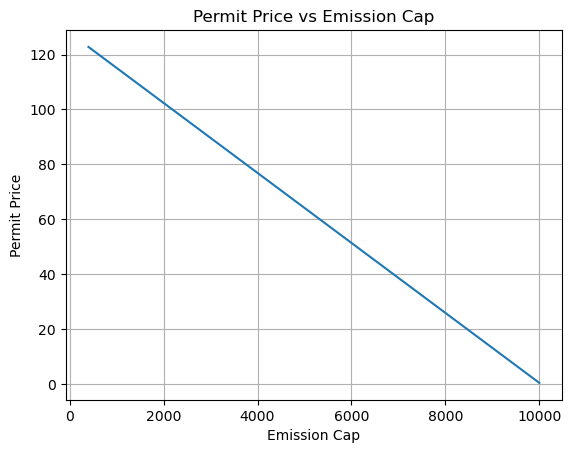

\begin{tabular}{lrr}
\toprule
 & Emission Cap & Permit Price \\
\midrule
0 & 400.000000 & 122.781785 \\
1 & 10000.000000 & 0.454747 \\
\bottomrule
\end{tabular}



In [ ]:
# Plot the results
plt.plot(caps[:30], permit_prices[:30])
plt.xlabel('Emission Cap')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Emission Cap')
plt.grid(True)
plt.show()
df = pd.DataFrame({'Emission Cap': caps[:33], 'Permit Price': permit_prices[:33]})
print(df.to_latex())

In [ ]:
# print pandas dataframe for latex output
#convert instances of Firm to a pandas dataframe
df = pd.DataFrame([vars(firm) for firm in firm_registry.values()])
# remove firms from the dataframe
#df = df.drop(columns = ['firms'])

#for firm in firm_registry.values():
print(df.to_latex(index=True))

\begin{tabular}{lrlllllrrr}
\toprule
 & id & name & sector & country & production_cost_function & abatement_cost_function & actual_output & emission & profit \\
\midrule
0 & 1 & firm1 & Sector(id=1, name='cement', firms=3) & Country(id=1, name='DE', firms=3) & 0 & 0.1*exp(x) + 100/y**2 & 257.325254 & 255.804328 & 6574.363755 \\
1 & 2 & firm2 & Sector(id=1, name='cement', firms=3) & Country(id=2, name='FI', firms=3) & 0 & 5*x**3.2 + 40/y**2 & 241.549450 & 241.334847 & 6171.203086 \\
2 & 3 & firm3 & Sector(id=1, name='cement', firms=3) & Country(id=3, name='GR', firms=3) & 0 & x**5.2 + 30/y**2 & 241.549450 & 240.981193 & 6171.357025 \\
3 & 4 & firm4 & Sector(id=2, name='steel', firms=3) & Country(id=1, name='DE', firms=3) & 0 & x**3.3 + 20/y**2 & 376.132227 & 375.705438 & 13809.690629 \\
4 & 5 & firm5 & Sector(id=2, name='steel', firms=3) & Country(id=2, name='FI', firms=3) & 0 & x**2.3 + 20/y**2 & 376.132227 & 375.873722 & 13809.629787 \\
5 & 6 & firm6 & Sector(id=2, name='steel', firms

In [ ]:
profits

[(9899078270.09168,
  704817575.4901737,
  111422805.9109365,
  110497376.53708106,
  791273099.9886072,
  133890794.07488467,
  249600637.21384504,
  99046745.01960957,
  97405307.31062396),
 (4398965706.482203,
  288246948.2701658,
  32298016.72251303,
  37445896.37208728,
  340026419.3155144,
  50621114.389433414,
  88156992.40891728,
  25688022.407844514,
  29402962.13616381),
 (3298955095.9770594,
  214933715.7404597,
  16473230.12375336,
  22835759.75019376,
  249778067.8800688,
  33967360.16134677,
  65868801.756328486,
  19016657.12327128,
  21802884.420651544),
 (2019383853.0401926,
  129653409.71853256,
  9697862.303511964,
  5840767.527922001,
  144797951.99065432,
  14595116.55336353,
  39942405.26993015,
  11256293.445209462,
  12962209.7453389)]